# Evaluer Mængden af cluster med inertia

Inertia Elbow Method er en måde man kan bruge til at hjælpe en med at finde en god mængde af clusters til kmeans. 
Jeg har dog også brugt silhouette(Silhouette_Evaluation.ipyn) til at evaluere mængden af clusters.


The k-Means objective function suggests we compare the evolution of the inertia or within-cluster variance. Initially, additional centroids decrease the inertia sharply because new clusters improve the overall fit. Once an appropriate number of clusters has been found (assuming it exists), new centroids reduce the within-cluster variance by much less as they tend to split natural groupings. 

Hence, when k-Means finds a good cluster representation of the data, the inertia tends to follow an elbow-shaped path similar to the explained variance ratio for PCA.


inertia er en error metric for kmeans clustering. 

Inertia (Cluster Sum of Squares):
- Inertia quantifies how well data points within a cluster are grouped together.
- It’s calculated by summing up the squared distances of each data point from the center of its assigned cluster.
- Smaller inertia values indicate more cohesive clusters, where data points are tightly grouped around their centroids.
- The goal is to minimize inertia by finding the optimal number of clusters.

K-Means Clustering:
- K-means is an unsupervised learning algorithm that partitions data into (k) clusters.
- It iteratively assigns data points to the nearest cluster centroid and recalculates centroids.
- The process continues until convergence (when centroids no longer change significantly).
- The final result is a set of clusters with minimized inertia.

Trade-Offs:
- While lower inertia is desirable, be cautious not to overfit the data by choosing too many clusters.
- Sometimes, a slightly higher inertia with fewer clusters may lead to better interpretability and generalization.

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from time import sleep
from numpy.random import uniform
from IPython import display

In [2]:
sns.set_style('white')
cmap = ListedColormap(sns.color_palette('Paired', 10))

In [3]:
data = pd.read_csv('data/heart_disease_cleaned.csv')

### PCA transformer datasættet

In [4]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

pca_x = pca_data[:, 0]
pca_y = pca_data[:, 1]

In [5]:
kmeans_kwargs = {
"init": "k-means++",
"n_init": 15,
"random_state": 42,
}

### Inertia Elbow Method

Det siges at den bedste mængde af clusters, er fundet ved at finde der hvor hakket ligner en albue.

Ud fra dette plot, kan man sige at både 2 og 3 clusters har den egenskab. Efter det bliver den for flad.

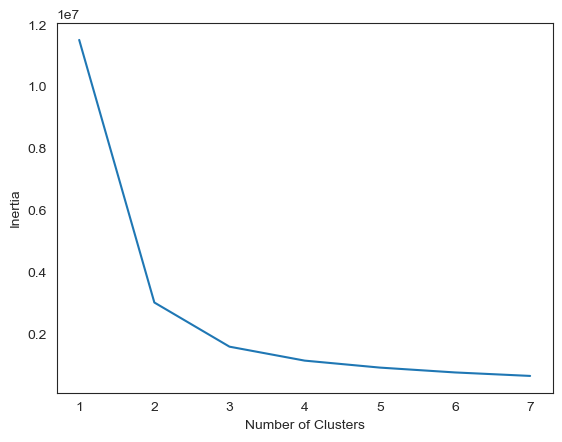

In [6]:
inertias = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pca_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 8), inertias)
plt.xticks(range(1, 8))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

### Nedenfor ses Inertia Elbow Method igen, bare med Voronoi plots sammen med.

Man kan bruge plots til at få bedre indsigt i dataen, og mængden af clusters.

In [7]:
n_clusters = 2

kmeans = KMeans(n_clusters, **kmeans_kwargs)

kmeans.fit(pca_data)

KMeans(n_clusters=2, n_init=15, random_state=42)

#### here we go. en masser spændende kode til at lave det flotte plot.

initialisere nogle variable og metoder til at lave plottet

In [8]:
x_min, x_max = pca_x.min() - 1, pca_x.max() + 1
y_min, y_max = pca_y.min() - 1, pca_y.max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, .01), 
                     np.arange(y_min, y_max, .01))

#### Den metode her er Inertia delen

In [9]:
def inertia_plot_update(inertias, ax, delay=1):
    inertias.plot(color='k',
                  lw=1,
                  title='Inertia',
                  ax=ax,
                  xlim=(inertias.index[0], inertias.index[-1]),
                  ylim=(0, inertias.max()))
    ax.set_xlabel(f"Clusters")
    ax.set_ylabel("Inertia Value")
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

In [10]:
def plot_kmeans_result(data, labels, centroids,
                       assignments, ncluster, Z, ax):

    # plot data
    ax.scatter(pca_x, pca_y, c=labels, s=20, cmap=cmap)

    # plot cluster centers
    ax.scatter(*centroids.T,
               marker='o',
               c='w',
               s=200,
               edgecolor='k',
               zorder=9)

    for i, c in enumerate(centroids):
        ax.scatter(*c,
                   marker=f'${i}$',
                   s=50,
                   edgecolor=['k'],
                   zorder=10)
        xy = pd.DataFrame(data[assignments == i],
                          columns=['x', 'y']).assign(cx=c[0],
                                                     cy=c[1])

        ax.plot(xy[['x', 'cx']].T.values,
                xy[['y', 'cy']].T.values,
                ls='--',
                color='k',
                lw=0.5)

    # plot voronoi
    ax.imshow(Z, interpolation='nearest',
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=cmap,
              aspect='auto',
              origin='lower',
              alpha=.2)
    ax.set_title(f'Number of Clusters: {ncluster}')
    plt.tight_layout()

In [11]:
max_clusters = 7
cluster_list = list(range(1, max_clusters + 1))
inertias = pd.Series(index=cluster_list)

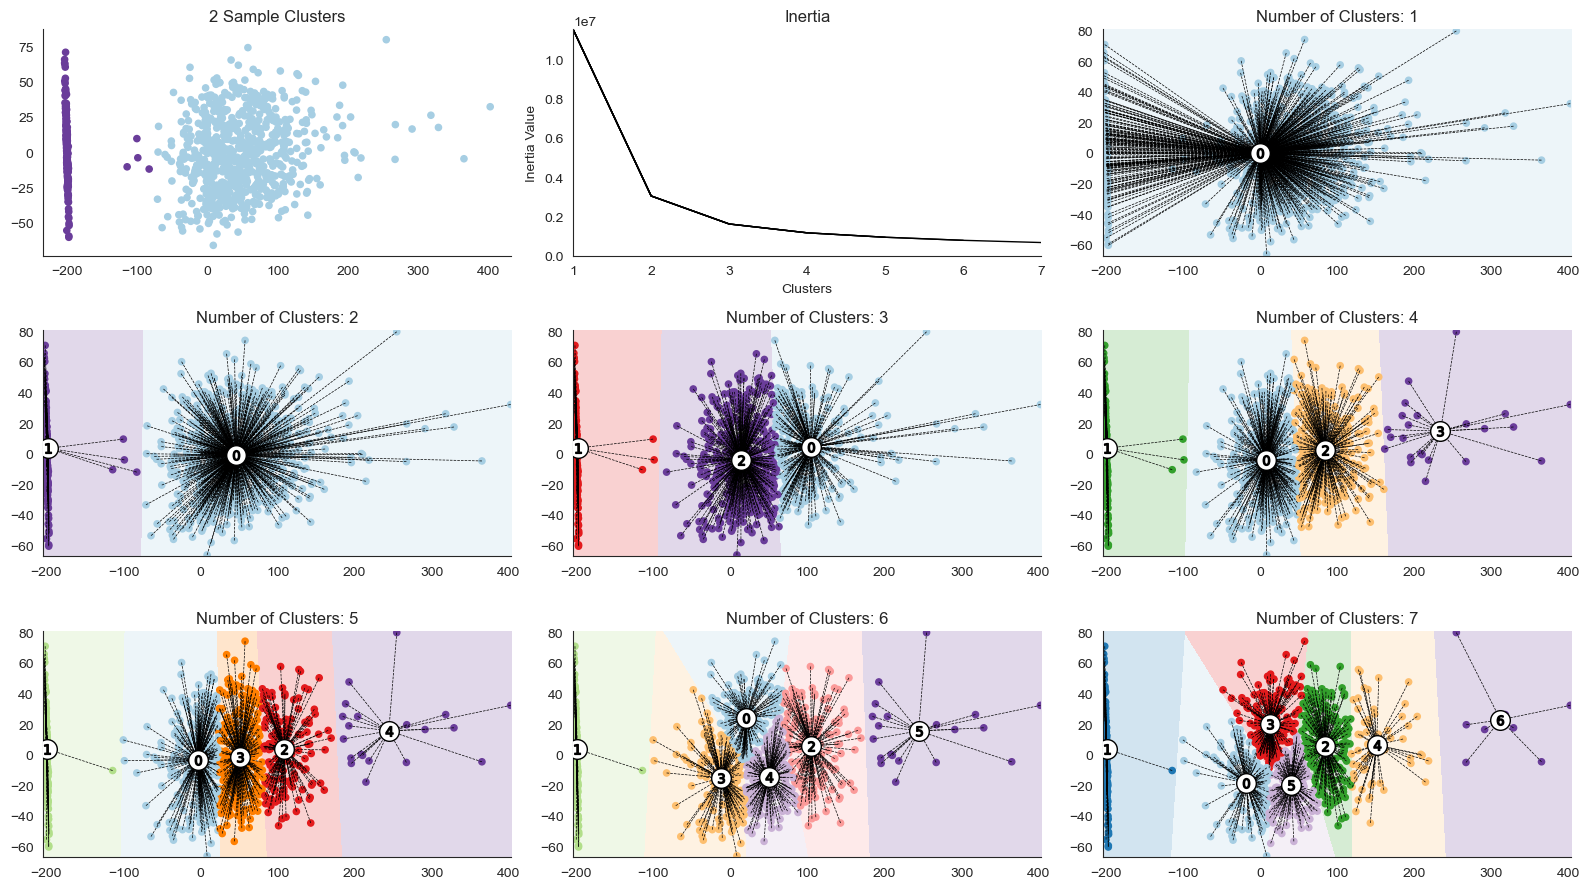

In [12]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(16, 9))
axes = np.array(axes).flatten()

axes[0].scatter(pca_x, pca_y, 
                c=kmeans.labels_, s=20, 
                cmap=cmap)
axes[0].set_title('{} Sample Clusters'.format(n_clusters))
for ax in axes:
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)
sns.despine();

for c, n_cluster in enumerate(range(1, max_clusters + 1), 2):
    kmeans = KMeans(n_clusters=n_cluster, **kmeans_kwargs).fit(pca_data)
    centroids, assignments, inertia = kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_
    inertias[n_cluster] = inertia
    inertia_plot_update(inertias, axes[1])
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plot_kmeans_result(pca_data, kmeans.labels_, centroids, assignments,  n_cluster, Z, axes[c])
fig.tight_layout()

# Resultatet

Når man kigger på plotsne. Kan man tydeligt se at den mængde clusters, som har de mest naturlige clusters, er 2. 

Der er 2 tydelige grupper. 

I alle de andre kommer grupperne meget tæt på hinanden, og man kan ikke rigtigt se hvilket cluster punkterne burde være i.